# Libraries and Data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#change directory
%cd /content/drive/MyDrive/Time Series Forecasting Product

/content/drive/MyDrive/Time Series Forecasting Product


In [3]:
#libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
#load the data
#YYYY-MM-DD
df = pd.read_csv('nyc_data.csv')
future_df = pd.read_csv('future.csv')
future_df.tail()

,Date,Demand,Easter,Thanksgiving,Christmas,Temperature,Marketing
26,1/27/2021,NaN,0,0,0,3.33,39.664
27,1/28/2021,NaN,0,0,0,1.67,195.314
28,1/29/2021,NaN,0,0,0,-2.78,235.894
29,1/30/2021,NaN,0,0,0,1.11,152.752
30,1/31/2021,NaN,0,0,0,4.44,158.620


In [7]:
# Merge these data sets
df = pd.concat([df, future_df])
df = df.reset_index(drop = True)
df.tail()

,Date,Demand,Easter,Thanksgiving,Christmas,Temperature,Marketing
2218,1/27/2021,NaN,0,0,0,3.33,39.664
2219,1/28/2021,NaN,0,0,0,1.67,195.314
2220,1/29/2021,NaN,0,0,0,-2.78,235.894
2221,1/30/2021,NaN,0,0,0,1.11,152.752
2222,1/31/2021,NaN,0,0,0,4.44,158.620


In [8]:
#Rename variable
df = df.rename(columns = {'Demand': 'y',
                          'Date': 'ds'})
df.head(0)

,ds,y,Easter,Thanksgiving,Christmas,Temperature,Marketing


In [9]:
# Transforming the date variable: YYYY-MM-DD
df.ds = pd.to_datetime(df.ds, format = "%m/%d/%Y")
df.head()

,ds,y,Easter,Thanksgiving,Christmas,Temperature,Marketing
0,2015-01-01,720.000885,0,0,0,3.68,41.305
1,2015-01-02,581.276773,0,0,0,4.73,131.574
2,2015-01-03,754.117039,0,0,0,7.23,162.700
3,2015-01-04,622.252774,0,0,0,10.96,160.281
4,2015-01-05,785.373319,0,0,0,6.92,51.077


# Holidays

In [10]:
# Easter Holiday
dates = df[df.Easter == 1].ds
easter = pd.DataFrame({'holiday': 'easter',
                       'ds': dates,
                       'lower_window': -5,
                       'upper_window': 2})
easter

,holiday,ds,lower_window,upper_window
94,easter,2015-04-05,-5,2
451,easter,2016-03-27,-5,2
836,easter,2017-04-16,-5,2
1186,easter,2018-04-01,-5,2
1571,easter,2019-04-21,-5,2
1928,easter,2020-04-12,-5,2


In [11]:
# Remaining Holidays
# Thanksgiving
dates = df[df.Thanksgiving == 1].ds
thanksgiving = pd.DataFrame({'holiday': 'thanksgiving',
                       'ds': dates,
                       'lower_window': -3,
                       'upper_window': 5})

#Christmas
dates = df[df.Christmas == 1].ds
christmas = pd.DataFrame({'holiday': 'christmas',
                       'ds': dates,
                       'lower_window': -7,
                       'upper_window': 7})

In [12]:
# Combine all events
holidays = pd.concat([easter, thanksgiving, christmas])
holidays.head()

,holiday,ds,lower_window,upper_window
94,easter,2015-04-05,-5,2
451,easter,2016-03-27,-5,2
836,easter,2017-04-16,-5,2
1186,easter,2018-04-01,-5,2
1571,easter,2019-04-21,-5,2


In [13]:
# Drop holidays from df
df_final = df.drop(columns = ["Easter", "Thanksgiving", "Christmas"])
df_final.head()

,ds,y,Temperature,Marketing
0,2015-01-01,720.000885,3.68,41.305
1,2015-01-02,581.276773,4.73,131.574
2,2015-01-03,754.117039,7.23,162.700
3,2015-01-04,622.252774,10.96,160.281
4,2015-01-05,785.373319,6.92,51.077


# Prophet Model

In [16]:
# Load the tuned parameters
parameters = pd.read_csv("Forecasting Product/best_params_prophet.csv",
                         index_col = 0)
parameters

,14
changepoint_prior_scale,0.01
holidays_prior_scale,20
seasonality_mode,additive
seasonality_prior_scale,20
rmse,48.4


In [30]:
# Extracting the parameters
cps = float(parameters.loc["changepoint_prior_scale"])
hps = float(parameters.loc["holidays_prior_scale"])
sps = float(parameters.loc["seasonality_prior_scale"])
sm = parameters.loc["seasonality_mode"][0]

In [38]:
# data
training = df_final.iloc[:-31, :]
future_df = df_final.iloc[-31:, :]

In [39]:
from prophet import Prophet

In [40]:
# Building the model
m = Prophet(holidays = holidays,
            seasonality_mode = sm,
            seasonality_prior_scale = sps,
            holidays_prior_scale = hps,
            changepoint_prior_scale = cps
            )
m.add_regressor("Temperature")
m.add_regressor("Marketing")
m.fit(training)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6smxbiy8/20mlbmy2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6smxbiy8/2zxwydpk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2237', 'data', 'file=/tmp/tmp6smxbiy8/20mlbmy2.json', 'init=/tmp/tmp6smxbiy8/2zxwydpk.json', 'output', 'file=/tmp/tmp6smxbiy8/prophet_modelxk6fzb63/prophet_model-20231025115857.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:58:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:58:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


# Forecasting

In [42]:
# Make a future dataframe
future = m.make_future_dataframe(periods = len(future_df),
                                 freq = "D") # W or M for weekly or Monthly
future = pd.concat([future, df_final.iloc[:, 2:]], axis = 1)
future.head()

,ds,Temperature,Marketing
0,2015-01-01,3.68,41.305
1,2015-01-02,4.73,131.574
2,2015-01-03,7.23,162.700
3,2015-01-04,10.96,160.281
4,2015-01-05,6.92,51.077


In [43]:
# Forecasting
forecast = m.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Marketing,Marketing_lower,Marketing_upper,Temperature,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01,595.314009,618.937921,762.213427,595.314009,595.314009,-3.449740,-3.449740,-3.449740,9.733632,...,-4.005876,-4.005876,-4.005876,96.100441,96.100441,96.100441,0.0,0.0,0.0,693.692466
1,2015-01-02,595.430180,540.783239,685.431973,595.430180,595.430180,0.197927,0.197927,0.197927,8.831786,...,-89.619038,-89.619038,-89.619038,94.793136,94.793136,94.793136,0.0,0.0,0.0,609.633992
2,2015-01-03,595.546351,655.876571,789.212720,595.546351,595.546351,1.455693,1.455693,1.455693,6.684533,...,25.165343,25.165343,25.165343,93.581275,93.581275,93.581275,0.0,0.0,0.0,722.433195
3,2015-01-04,595.662522,569.343468,707.052399,595.662522,595.662522,1.357944,1.357944,1.357944,3.480831,...,-55.456285,-55.456285,-55.456285,92.484351,92.484351,92.484351,0.0,0.0,0.0,637.529363
4,2015-01-05,595.778693,692.410649,835.178647,595.778693,595.778693,-3.054865,-3.054865,-3.054865,6.950792,...,74.027811,74.027811,74.027811,91.517777,91.517777,91.517777,0.0,0.0,0.0,765.220208


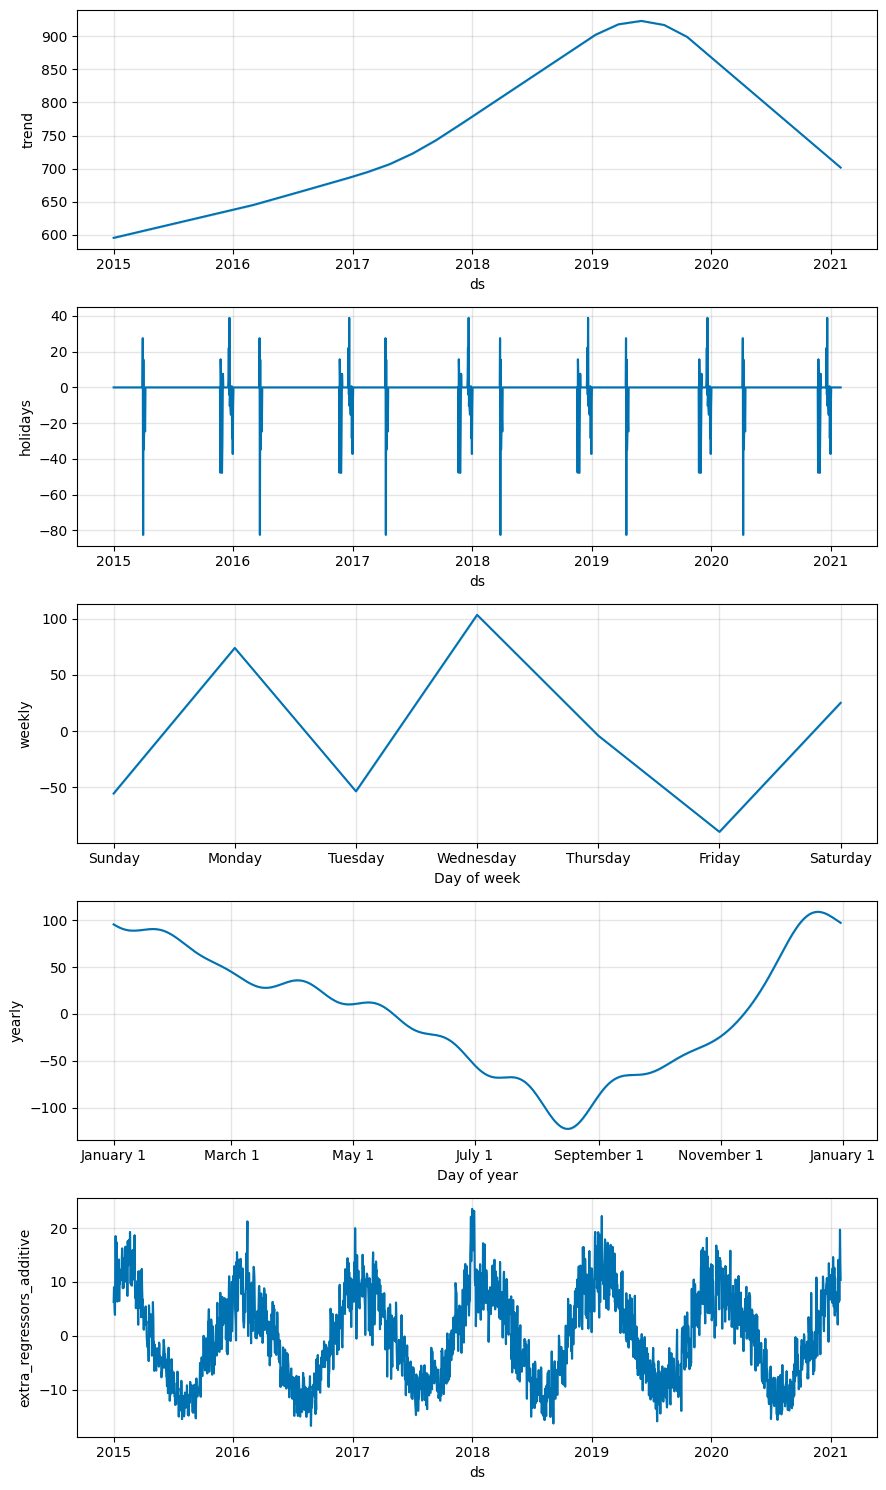

In [44]:
# Components
m.plot_components(forecast);

In [ ]:
# Extracting the predictions
predictions_prophet = forecast.yhat[-len(future_df):].rename("prophet")
predictions_prophet.index = future_df["ds"]
predictions_prophet

In [51]:
# Exporting
predictions_prophet.to_csv("Forecasting Product/Ensemble/predictions_prophet.csv")